In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import config
from google.cloud import bigquery
from google.oauth2 import service_account

#Import Data

In [3]:
#load credentials
credentials = service_account.Credentials.from_service_account_file(config.credentials)
client = bigquery.Client(credentials=credentials, project=credentials.project_id,)

#save data to datafram
sql = """
select
  *
from `fantasy-football-415601.fantasy_football.player_by_season`
where fantpos = 'RB'
"""
df = client.query(sql).to_dataframe()

#Clean data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 43 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              783 non-null    int64  
 1   rank               783 non-null    int64  
 2   player             783 non-null    object 
 3   tm                 783 non-null    object 
 4   fantpos            783 non-null    object 
 5   age                783 non-null    int64  
 6   g                  783 non-null    int64  
 7   gs                 783 non-null    int64  
 8   passing_cmp        783 non-null    float64
 9   passing_att        783 non-null    float64
 10  passing_yds        783 non-null    float64
 11  passing_td         783 non-null    float64
 12  passing_int        783 non-null    float64
 13  rushing_att        783 non-null    float64
 14  rushing_yds        783 non-null    float64
 15  rushing_yds_att    783 non-null    float64
 16  rushing_td         783 non

#Running Backs

In [5]:
rb = (
    df.loc[:,['player','ppr','g','gs','rushing_att','rushing_yds_att','rushing_td','rushing_yds_g','rushing_att_g','rushing_td_g','receiving_tgt',
            'receiving_yds_rec','receiving_yds_g','receiving_tgt_g','receiving_rec_g','receiving_td_g','fmb','fl','td','td_g']]
)

In [6]:
rb.head()

,player,ppr,g,gs,rushing_att,rushing_yds_att,rushing_td,rushing_yds_g,rushing_att_g,rushing_td_g,receiving_tgt,receiving_yds_rec,receiving_yds_g,receiving_tgt_g,receiving_rec_g,receiving_td_g,fmb,fl,td,td_g
0,Chris Thompson,93.6,11,0,37.0,3.73,0.0,12.545455,3.363636,0.0,58.0,9.00,34.363636,5.272727,3.818182,0.0,1.0,0.0,0,0.0
1,Jalen Richard,82.8,16,0,39.0,3.72,0.0,9.062500,2.437500,0.0,43.0,8.97,20.187500,2.687500,2.250000,0.0,2.0,0.0,0,0.0
2,Giovani Bernard,68.4,16,2,53.0,3.21,0.0,10.625000,3.312500,0.0,43.0,7.80,14.625000,2.687500,1.875000,0.0,2.0,1.0,0,0.0
3,Ty Johnson,60.2,16,1,63.0,4.33,0.0,17.062500,3.937500,0.0,31.0,4.54,6.812500,1.937500,1.500000,0.0,1.0,1.0,0,0.0
4,Mark Walton,42.0,7,4,53.0,3.79,0.0,28.714286,7.571429,0.0,21.0,5.93,12.714286,3.000000,2.142857,0.0,1.0,1.0,0,0.0


In [7]:
rb.describe()

,ppr,g,gs,rushing_att,rushing_yds_att,rushing_td,rushing_yds_g,rushing_att_g,rushing_td_g,receiving_tgt,receiving_yds_rec,receiving_yds_g,receiving_tgt_g,receiving_rec_g,receiving_td_g,fmb,fl,td,td_g
count,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.00000,783.000000,783.000000
mean,76.291954,10.781609,3.524904,73.357599,3.568020,2.288633,24.734364,5.851876,0.181488,20.799489,6.058723,9.323466,1.630884,1.258333,0.045721,0.784163,0.44189,2.909323,0.227209
std,85.051535,5.227516,5.148841,82.046380,1.894875,3.347857,25.141914,5.511262,0.261558,23.741078,4.012165,10.020038,1.586584,1.255765,0.091607,1.199170,0.80050,3.952170,0.299088
min,-4.000000,0.000000,0.000000,0.000000,-12.000000,0.000000,-12.000000,0.000000,0.000000,0.000000,-3.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,7.850000,6.000000,0.000000,8.000000,2.890000,0.000000,3.721154,1.000000,0.000000,2.000000,4.100000,1.081250,0.333333,0.214286,0.000000,0.000000,0.00000,0.000000,0.000000
50%,42.700000,12.000000,1.000000,38.000000,3.970000,1.000000,15.666667,4.000000,0.071429,12.000000,6.440000,6.312500,1.200000,1.000000,0.000000,0.000000,0.00000,1.000000,0.125000
75%,125.200000,16.000000,5.000000,119.000000,4.590000,3.000000,43.235417,9.966667,0.285714,33.500000,8.270000,13.723810,2.500000,2.000000,0.066667,1.000000,1.00000,4.000000,0.375000
max,471.200000,17.000000,17.000000,378.000000,10.000000,18.000000,126.687500,27.375000,2.000000,142.000000,33.000000,62.812500,8.875000,7.250000,1.000000,7.000000,5.00000,21.000000,2.000000


Many of the stats do not have a normal distribution. This makes sense as many active players may not get a lot of snaps. We'll need to exclude outliers.

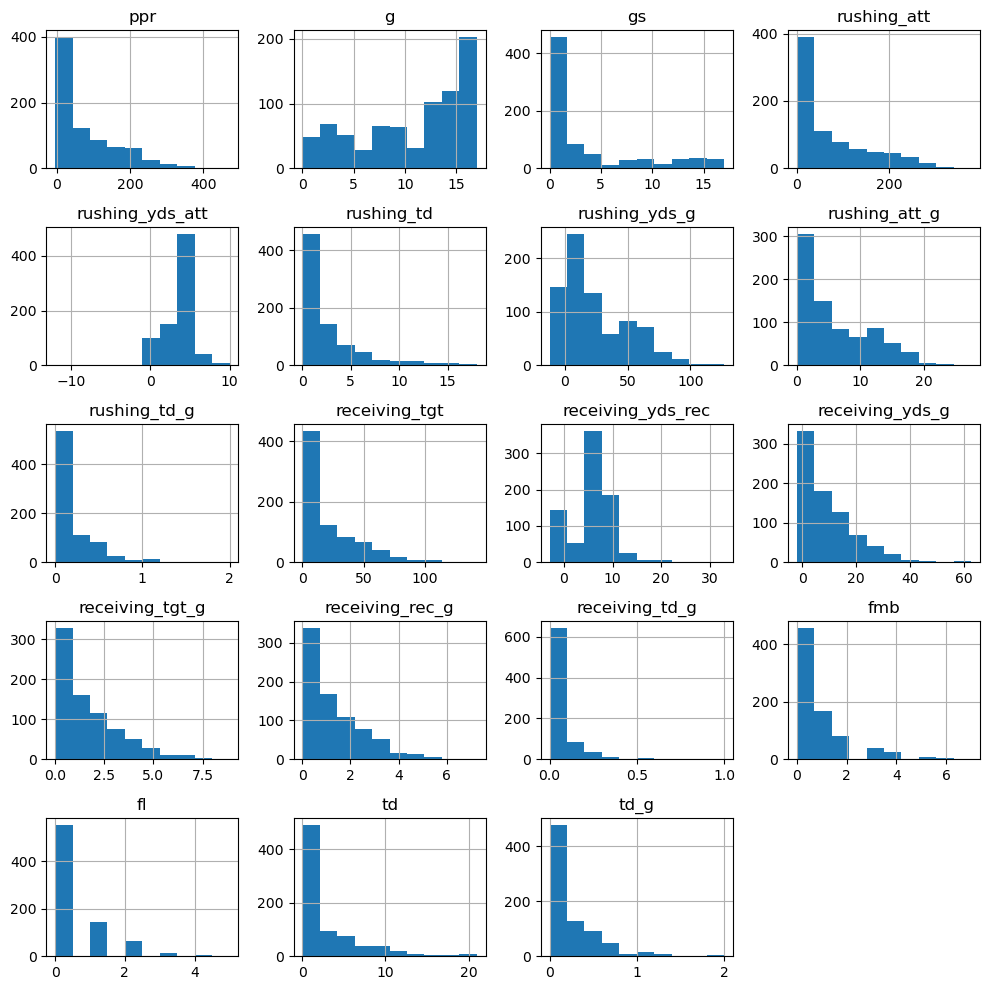

In [8]:
rb.hist(bins=10, figsize=(10, 10))
plt.tight_layout()
plt.show()

There are several columns with high correlation which we should consider dropping. Let's leave the per game metrics and exclude the totals, as it will be more helpful when analyzing player performance during the season.

<Axes: >

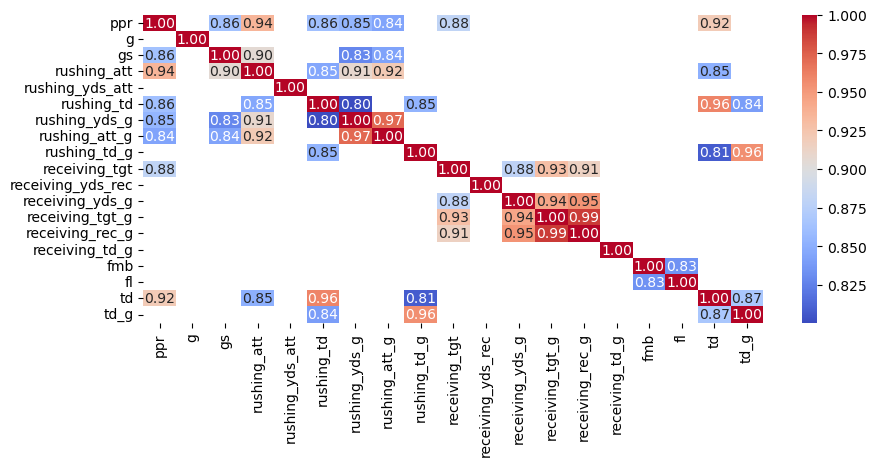

In [9]:
corr_matrix = rb.drop(columns=['player']).corr()
mask = corr_matrix.map(lambda x: x < 0.8 and x != 1)

plt.figure(figsize=(10, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)

In [11]:
#select just per game metrics
rb_g = rb.loc[:,['player','ppr','g','gs','rushing_yds_att','rushing_yds_g','rushing_att_g','rushing_td_g',
                'receiving_yds_rec','receiving_rec_g','receiving_yds_g','receiving_tgt_g','receiving_td_g','td_g']]

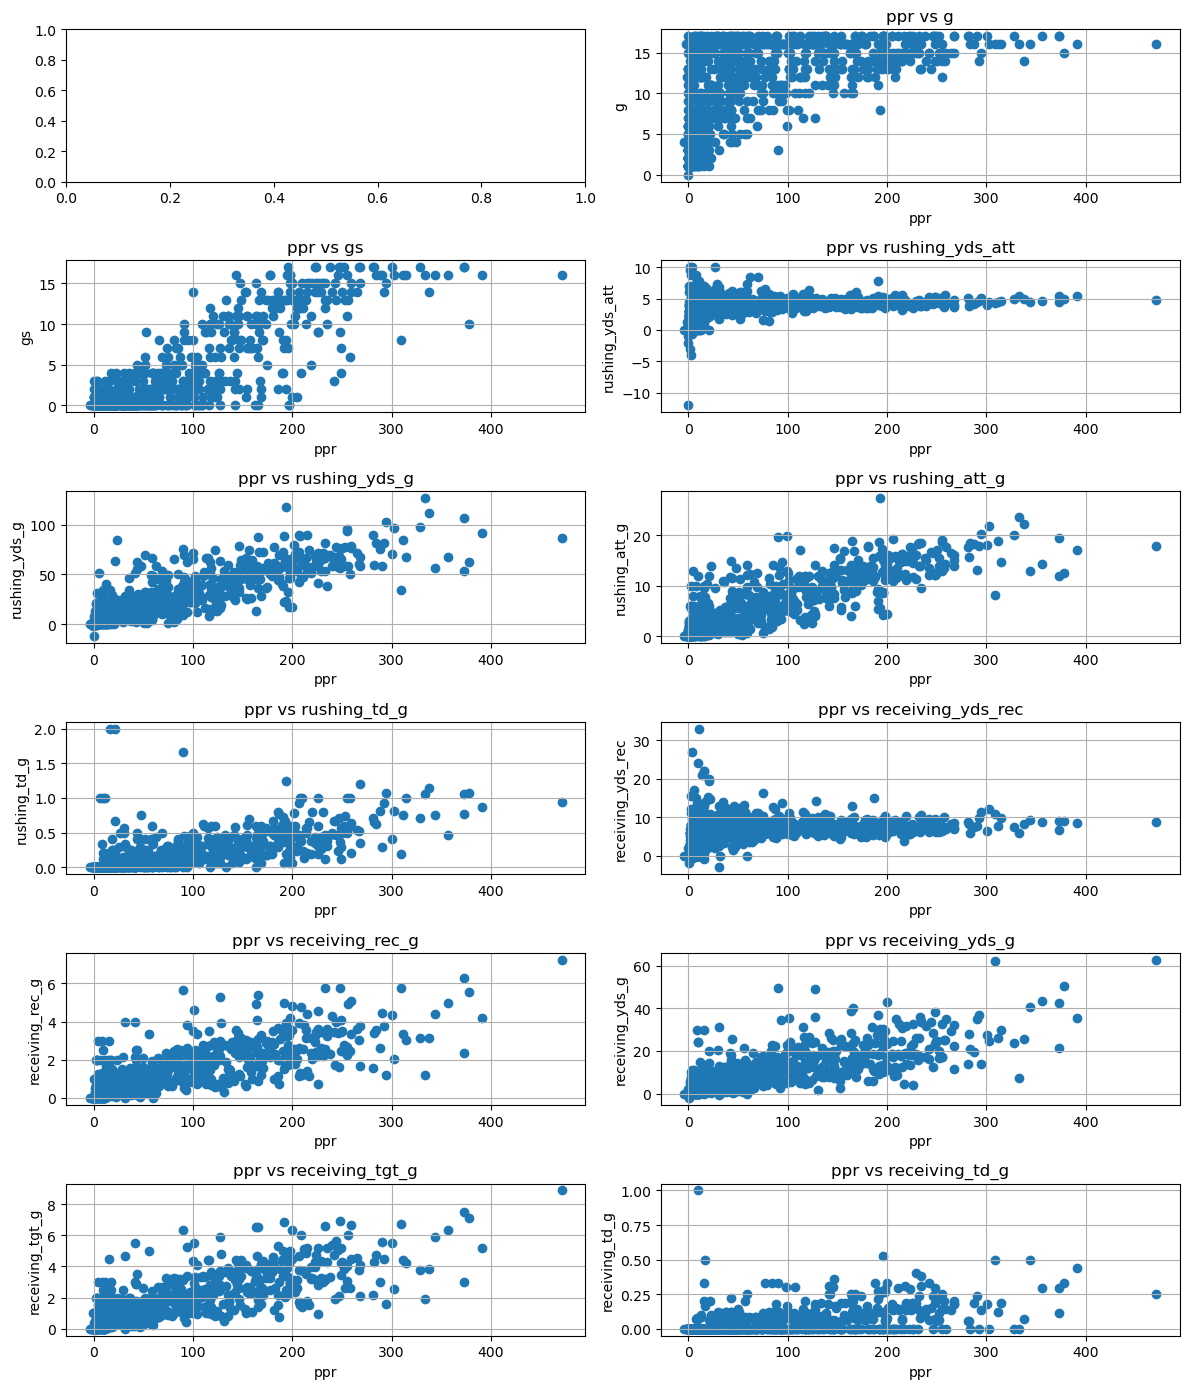

In [12]:
# Select the column for which scatterplots will be created
selected_column = 'ppr'
rb_scatter = rb_g.iloc[:,1:13] #exclude the players name column

num_cols = len(rb_scatter.columns) - 1
num_rows = num_cols // 2 if num_cols % 2 == 0 else num_cols // 2 + 1

# Create scatterplots in a grid
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 14))

# Flatten the axes array to make indexing easier
axes = axes.flatten()

for i, column in enumerate(rb_scatter.columns):
    if column != selected_column:
        ax = axes[i]
        ax.scatter(rb_scatter[selected_column], rb_scatter[column])
        ax.set_title(f'{selected_column} vs {column}')
        ax.set_xlabel(selected_column)
        ax.set_ylabel(column)
        ax.grid(True)


plt.tight_layout()
plt.show()

In [13]:
#for players that started at least a game, the percentiles are much different
rb.loc[rb['gs']>0]['ppr'].describe()

count    402.000000
mean     128.888557
std       86.785909
min        0.000000
25%       57.525000
50%      117.850000
75%      191.325000
max      471.200000
Name: ppr, dtype: float64

In [14]:
#remove outliers

#There is a large cluster of players between 0-50 ppr that the model is having trouble predict, so remove them. Also remove christian mccaffrey as his ppr total is a heavy outlier
rb_g = rb_g.loc[rb_g['ppr']>50]

#remove outlier ppr players based on IQR
def remove_outliers_iqr(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered

#create loop to run on list of columns. including columns were major outliers were noticed in scatter plots
for column in rb_g.loc[:,['ppr']]:
    rb_g = remove_outliers_iqr(rb_g,column)

#apply transformations to key metrics. td metrics look to have exponential relationship with ppr
rb_g['td_g_sq'] = rb_g['td_g']**2
rb_g['rushing_td_g_sq'] = rb_g['rushing_td_g']**2
rb_g['receiving_td_g_sq'] = rb_g['receiving_td_g']**2

#Regression

In [15]:
X = rb_g.iloc[:,np.r_[2:17]]
y = rb_g['ppr']
X = sm.add_constant(X)

result = sm.OLS(y,X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    ppr   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     767.2
Date:                Tue, 27 Feb 2024   Prob (F-statistic):          1.58e-248
Time:                        20:58:58   Log-Likelihood:                -1402.1
No. Observations:                 357   AIC:                             2834.
Df Residuals:                     342   BIC:                             2892.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -159.1374      9.14

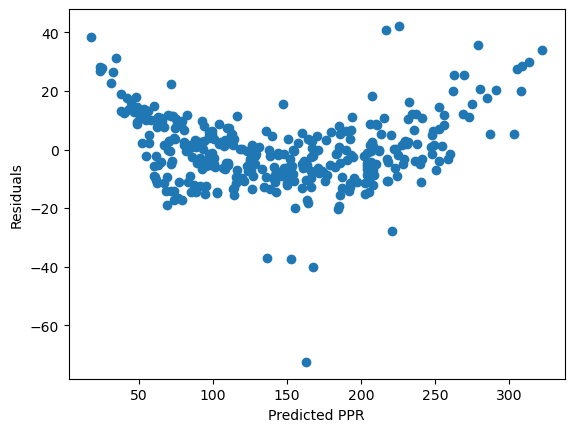

In [16]:
rb_g['ppr_predict'] = result.predict(X)

rb_g['residuals'] = rb_g['ppr'] - rb_g['ppr_predict']

# Create residual plot
plt.scatter(rb_g['ppr_predict'],rb_g['residuals'])
plt.xlabel('Predicted PPR')
plt.ylabel('Residuals')

plt.show()

<Axes: >

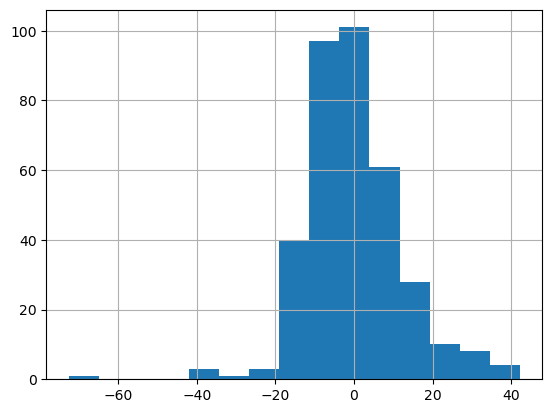

In [17]:
rb_g['residuals'].hist(bins=15)